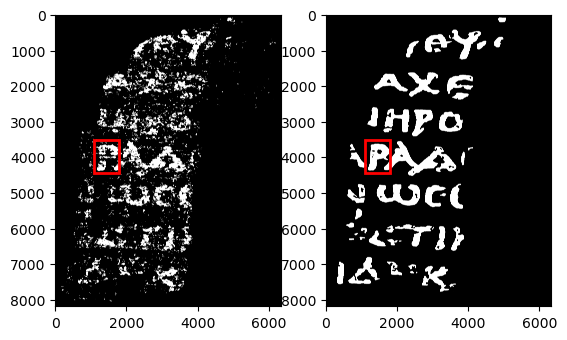

In this notebook I modify the [Tutorial notebook](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial) to produce the model's predictions for the entire image in a quick matter. 

This is done by only predicting pixels sparsely and extrapolating the data to create a full mask.

The predictions produced by the model are shown below:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
import pandas as pd

PREFIX = '/kaggle/input/vesuvius-challenge-ink-detection/train/1/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [ ]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
    ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

In [ ]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu(), cmap = "gray")
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [ ]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()).to(DEVICE)

In [ ]:
def get_pixels(stride = 0):
    """
    if not sparse: returns (inside_rect, outside rect) within the mask and outside the buffer

    """

    max_h,max_w = mask.shape # Height and width of mask
    x, y, w, h = rect

    # Create a Boolean array of the same shape as the bitmask, initially all True
    not_border = np.zeros(mask.shape, dtype=bool)
    not_border[BUFFER:max_h-BUFFER, BUFFER:max_w-BUFFER] = True
    arr_mask = np.array(mask) * not_border

    inside_rect = np.zeros(mask.shape, dtype=bool)
    # Sets all indexes with inside_rect array to true
    inside_rect[y:y+h+1, x:x+w+1] = True
    inside_rect = inside_rect*arr_mask

    if stride != 0:
        assert stride % 2 == 1, "sparse has to be an odd number!"
        sparse_mask = np.zeros(mask.shape, dtype=bool)
        sparse_mask[::stride, ::stride] = True
        sparse_mask = sparse_mask*arr_mask

        #sparse inside, full set
        return np.argwhere(inside_rect*sparse_mask), np.argwhere(sparse_mask)    

    outside_rect = arr_mask #np.ones(mask.shape, dtype=bool) * arr_mask
    # Set the pixels within the inside_rect to False
    outside_rect[y:y+h+1, x:x+w+1] = False

    return np.argwhere(inside_rect), np.argwhere(outside_rect)
    
pixels_inside_rect, pixels_outside_rect = get_pixels()

In [ ]:
print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
running_loss = 0.0
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS, leave = True):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
    running_loss += loss.item()
    if i % 3000 == 3000-1:
        print(f"Loss: {running_loss / 3000:.4f}")
        running_loss = 0.0

In [ ]:
stride = 9
inside_sparse, all_sparse = get_pixels(stride=stride)
pixels = all_sparse
print(len(pixels))

display_dataset = SubvolumeDataset(image_stack, label, pixels)
display_loader = data.DataLoader(display_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(display_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            y, x = pixels[i*BATCH_SIZE+j]
            output[y, x] = value

output = output.cpu().numpy()

#fill in pixels
spacing = stride//2
hor_filled = np.zeros(output.shape)
for i in range(2*spacing):# duplicating horizontally
    hor_filled[:, spacing:-spacing] += output[:, i:-2*spacing+i].copy()
hor_filled[:, spacing:-spacing] += output[:, 2*spacing:].copy()

filled = np.zeros(hor_filled.shape)
for i in range(2*spacing):# duplicating vertically
    filled[spacing:-spacing] += hor_filled[i:-2*spacing+i].copy()
filled[spacing:-spacing] += hor_filled[2*spacing:].copy()

output = torch.Tensor(filled)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [ ]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
patch1 = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
patch2 = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(patch1)
ax2.add_patch(patch2)
plt.show()

In [ ]:
x, y, w, h = rect
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output[y:y+h+1, x:x+w+1].gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label[y:y+h+1, x:x+w+1].cpu(), cmap='gray')
plt.show()

## Creating predictions for test set

In [ ]:
stride = 9
outputs = []
for test_label in ['a', 'b']:
    print("-"*25,PREFIX,"-"*25)
    PREFIX = f'/kaggle/input/vesuvius-challenge-ink-detection/test/{test_label}/'.format(test_label)
    mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
    images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
    image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)
    
    inside_sparse, all_sparse = get_pixels(stride=stride)
    pixels = all_sparse
    print(len(pixels))

    display_dataset = SubvolumeDataset(image_stack, label, pixels)
    display_loader = data.DataLoader(display_dataset, batch_size=BATCH_SIZE, shuffle=False)
    output = torch.zeros_like(label).float()
    model.eval()
    with torch.no_grad():
        for i, (subvolumes, _) in enumerate(tqdm(display_loader)):
            for j, value in enumerate(model(subvolumes.to(DEVICE))):
                y, x = pixels[i*BATCH_SIZE+j]
                output[y, x] = value

    output = output.cpu().numpy()

    #fill in pixels
    spacing = stride//2
    hor_filled = np.zeros(output.shape)
    for i in range(2*spacing):# duplicating horizontally
        hor_filled[:, spacing:-spacing] += output[:, i:-2*spacing+i].copy()
    hor_filled[:, spacing:-spacing] += output[:, 2*spacing:].copy()

    filled = np.zeros(hor_filled.shape)
    for i in range(2*spacing):# duplicating vertically
        filled[spacing:-spacing] += hor_filled[i:-2*spacing+i].copy()
    filled[spacing:-spacing] += hor_filled[2*spacing:].copy()
    output = torch.Tensor(filled)
    outputs.append(output)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(output.cpu(), cmap='gray')
    ax2.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
def rle(img, threshold=0.5):
    flat_img = img.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix

    return starts_ix, lengths

In [ ]:
pred_list = []
starts_ix, lengths = rle(outputs[0], threshold=0.4)
inklabels_rle = " ".join(map(str, sum(zip(starts_ix, lengths), ())))
print(len(inklabels_rle))
pred_list.append({"Id": 'a', "Predicted": inklabels_rle})

starts_ix, lengths = rle(outputs[1], threshold=0.4)
inklabels_rle = " ".join(map(str, sum(zip(starts_ix, lengths), ())))
print(len(inklabels_rle))
pred_list.append({"Id": 'b', "Predicted": inklabels_rle})

In [ ]:
pd.DataFrame(pred_list).to_csv("submission.csv", index=False)